In [2]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting_and_analysis import plot_utils, summary_plots, spatial_fits, analysis_utils
plot_utils.set_plotting_defaults()

In [14]:
subject = 1
volume_space=True
# fitting_type = 'bdcn_pca_fused'
# fitting_type1 = 'texture_pyramid_ridge_4ori_4sf'
fitting_type1 = 'gabor_solo_ridge_4ori_4sf'
# fitting_type1 = 'texture_gabor_ridge_4ori_4sf'
# fitting_type2 = 'sketch_tokens'
fitting_type2 = 'texture_pyramid_ridge_4ori_4sf'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out1, fig_save_folder = analysis_utils.load_fit_results(subject, volume_space, fitting_type1, n_from_end=0, root=root, verbose=True);
# analysis_utils.print_output_summary(out1)

out2, fig_save_folder = analysis_utils.load_fit_results(subject, volume_space, fitting_type2, n_from_end=0, root=root, verbose=True);
# analysis_utils.print_output_summary(out2)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)
    


loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_4ori_4sf/Sep-20-2021_1819_56/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'feature_info', 'nonlin_fn', 'padding_mode', 'autocorr_output_pix', 'group_all_hl_feats'])
loading from /user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf/Aug-23-2021_2357/all_fit_params

dict_keys(['aperture', 'aperture_rf_range', 'models', 'feature_info', 'voxel_mask', 'brain_nii_shape', 'image_o

In [10]:
fig_save_folder = '/user_data/mmhender/imStat/figures/S01/compare_models/'
# os.makedirs(fig_save_folder)

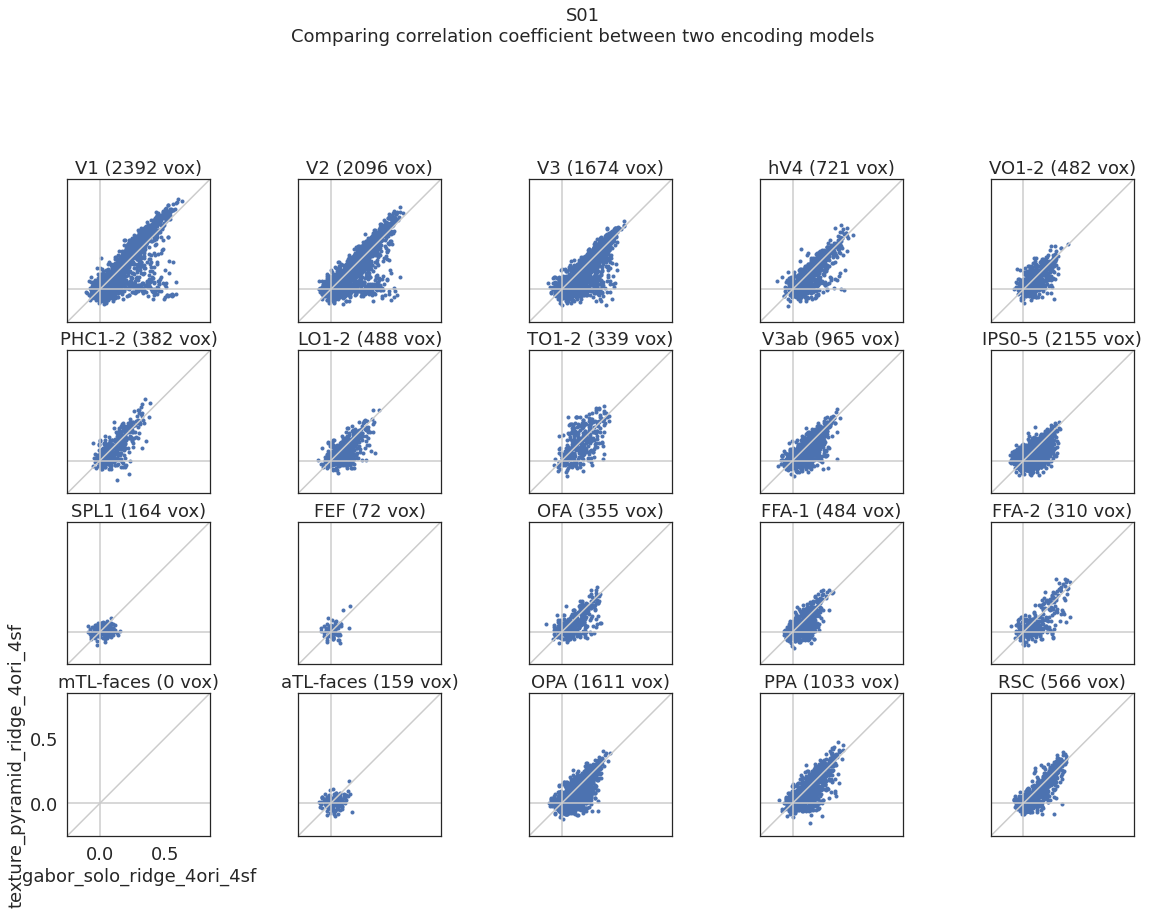

In [17]:
plot_utils.set_all_font_sizes(fs = 18)
cc_cutoff = 0.20
val_cc1 = out1['val_cc'][:,0:1]
val_cc2 = out2['val_cc'][:,0:1]
dat = np.concatenate((val_cc1,val_cc2), axis=1)

inds2use = np.ones([len(val_cc1),])==1

sp = plot_utils.scatter_plot(color=None, xlabel=fitting_type1, ylabel=fitting_type2, \
                             xlims=[-0.25, 0.85], ylims=[-0.25, 0.85], \
                  xticks=[0, 0.5], yticks=[0, 0.5],\
                  show_diagonal=True, show_axes=True);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out1,\
                    suptitle='S%02d\nComparing correlation coefficient between two encoding models'%(subject), \
                   label_just_corner=True, figsize=(20,24))

plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.pdf'%(fitting_type1, fitting_type2)))
    plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.png'%(fitting_type1, fitting_type2)))